# Complementaria Semana 6: Simulación de una cola M/M/1 con SimPy

En la complementaria anterior aprendimos los elementos básicos de SimPy: `Environment`, procesos con `yield`, y recursos (`Resource`) que representan servidores compartidos con cola.

En esta complementaria construiremos un modelo completo de una cola **M/M/1**:
- llegadas aleatorias (Proceso de Poisson) con tasa $\lambda$,
- tiempos de servicio exponenciales con tasa $\mu$,
- un solo servidor (capacidad 1),
- cola FIFO, sin abandonos.

Además, recolectaremos métricas de desempeño típicas:
- $W_q$: espera promedio en cola
- $W$: tiempo promedio en el sistema
- $L_q$ y $L$: número promedio en cola y en sistema (vía Ley de Little)
- utilización del servidor $\rho$ (observada y teórica)
- percentiles (p50, p90) de la espera


### Objetivos

Al final de esta guía podrás:

1. Implementar una cola M/M/1 en SimPy usando `Resource`.
2. Programar un generador de llegadas con interarribos exponenciales.
3. Medir tiempos de espera y tiempos en sistema por cliente completado.
4. Calcular utilización, $W_q$, $W$, $L_q$, $L$ y percentiles.
5. Comparar simulación con teoría cuando $\lambda < \mu$.

### Librerías que usaremos
- `numpy` para muestreo y cálculo numérico
- `matplotlib` para visualización
- `pandas` para dataframes (tablas)
- `simpy` para la simulación de eventos discretos (entorno, procesos y recursos)
- `random` para generar variables aleatorias (por ejemplo, exponenciales con `expovariate`)
- `statistics` para promedios simples de métricas simuladas



Si aún no están instaladas en el entorno, utilizar este comando en una celda de python (no es necesario instalar `math`):

In [5]:
pip install numpy matplotlib pandas simpy statistics

Note: you may need to restart the kernel to use updated packages.


Posteriormente, importar las librerías:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import simpy
import random
import statistics


## Marco teórico (M/M/1) y qué estamos estimando con la simulación

### 1) Definición del modelo M/M/1
Una cola **M/M/1** se caracteriza por:

- Llegadas según un proceso de Poisson de tasa $\lambda>0$. Equivalentemente, los **tiempos entre llegadas** $(A_i)$ son i.i.d. exponenciales:
  $$
  A_i \sim \mathrm{Exp}(\lambda), \qquad \mathbb{E}[A_i]=\frac{1}{\lambda}.
  $$

- Tiempos de servicio i.i.d. exponenciales de tasa $\mu>0$:
  $$
  S_i \sim \mathrm{Exp}(\mu), \qquad \mathbb{E}[S_i]=\frac{1}{\mu}.
  $$

- Un servidor (capacidad 1) y disciplina típica **FCFS** (*First-Come First-Served*).

El estado natural del sistema es
$$
N(t)=\text{número de clientes en el sistema (en cola + en servicio) en el tiempo }t.
$$
Bajo las hipótesis M/M/1, $(N(t))_{t\ge 0}$ es una **cadena de Markov en tiempo continuo** (CTMC) tipo *birth–death* con transiciones:
$$
n \to n+1 \text{ a tasa } \lambda, \qquad
n \to n-1 \text{ a tasa } \mu \text{ si } n\ge 1.
$$

### 2) Estabilidad y utilización
Definimos la **intensidad de tráfico** o **utilización**:
$$
\rho=\frac{\lambda}{\mu}.
$$
- Si $\rho<1$, el sistema es **estable**: existe distribución estacionaria y las métricas promedio son finitas.
- Si $\rho\ge 1$, el sistema es **inestable**: el número en cola crece sin límite en promedio.

En régimen estacionario (cuando $\rho<1$), el servidor está ocupado una fracción $\rho$ del tiempo.

### 3) Resultados analíticos (lo que esperamos ver)
Cuando $\rho<1$, la distribución estacionaria de $N$ es geométrica:
$$
\pi_n=\mathbb{P}(N=n)=(1-\rho)\rho^n,\qquad n=0,1,2,\dots
$$
De allí se obtienen las métricas clásicas:

- Número esperado en el sistema:
  $$
  L=\mathbb{E}[N]=\frac{\rho}{1-\rho}.
  $$

- Tiempo esperado en el sistema:
  $$
  W=\mathbb{E}[\text{tiempo en sistema}]=\frac{1}{\mu-\lambda}.
  $$

- Tiempo esperado en cola:
  $$
  W_q=W-\frac{1}{\mu}=\frac{\lambda}{\mu(\mu-\lambda)}.
  $$

- Número esperado en cola:
  $$
  L_q=\lambda W_q=\frac{\rho^2}{1-\rho}.
  $$

Además, se cumple la **Ley de Little** (en estacionario):
$$
L=\lambda W,\qquad L_q=\lambda W_q.
$$
Estas identidades son un chequeo de consistencia muy útil: si la simulación está bien instrumentada y el horizonte es grande, las estimaciones deberían ser cercanas a las fórmulas teóricas y coherentes con Little.



### 4) Qué hace SimPy y cómo se traduce un modelo de colas a código

La idea central es que el tiempo simulado **no avanza en pasos fijos**
(como “cada 0.01 segundos”), sino que avanza **saltando de evento en evento**. En una cola, los eventos típicos son:
llegadas, comienzos de servicio y salidas (fin de servicio). Entre eventos, el estado del sistema no cambia.

En SimPy, hay cuatro conceptos que debes identificar siempre:

1) **Environment (`env`)**
- Es el “mundo” de la simulación: contiene el **reloj simulado** y la agenda de eventos.
- `env.now` devuelve el **tiempo actual** (simulado).
- `env.run(until=T)` hace correr la simulación hasta el tiempo `T` (o hasta que no haya eventos).

2) **Procesos (funciones con `yield`)**
Un “proceso” en SimPy se escribe como una función (normalmente con `def`) que usa `yield`.  
Ese `yield` NO es un “truco” de Python al azar: significa que el proceso **cede el control** a SimPy y queda **pausado**
hasta que ocurra algo.

Los dos `yield` más comunes en colas son:

- `yield env.timeout(x)`  
  Interpreta: “espera **x** unidades de tiempo simulado”.  
  En una cola M/M/1 se usa para:
  - **interarribos**: `x = Exp(λ)`
  - **servicios**: `x = Exp(μ)`

- `yield req` donde `req = resource.request()`  
  Interpreta: “espera hasta conseguir el recurso”.  
  Si el recurso está ocupado, el cliente queda en cola. Cuando el recurso se libera, SimPy reanuda el proceso y el `yield req`
  termina (ya tienes el servidor).

Por eso, en un cliente típico verás el patrón:
- llega en `t = env.now`
- pide servidor y espera: `yield req`
- cuando lo consigue, genera un servicio `s` y espera: `yield env.timeout(s)`
- al terminar, libera el servidor automáticamente al salir del bloque `with`

3) **Resources (`simpy.Resource`)**
Un `Resource` modela un recurso con capacidad limitada. Para M/M/1:
- `capacity = 1` representa **un solo servidor**.
- Si `capacity = c`, eso es una M/M/c.

El uso típico es:
- `with server.request() as req:` crea una solicitud
- `yield req` hace que el cliente espere si el servidor está ocupado
- cuando sales del `with`, el servidor queda libre (no tienes que “liberarlo” manualmente)

Intuición importante para colas:
- Si `server.count` es 1, el servidor está ocupado (en M/M/1).
- Si hay solicitudes esperando, están en `server.queue` (cola interna del recurso).

4) **Cómo conectar los procesos: `env.process(...)`**
SimPy necesita que le “lances” procesos para que corran en paralelo (en el sentido de concurrencia simulada):
- `env.process(cliente(...))` crea un proceso cliente y lo agenda.
- Un generador de llegadas típicamente hace:
  - espera un interarribo con `yield env.timeout(...)`
  - crea un cliente con `env.process(cliente(...))`
  - repite para generar muchos clientes

Esto es lo que convierte una descripción matemática (Poisson + Exponencial + servidor) en una dinámica simulada.

#### Traducción directa M/M/1 → SimPy (mapa mental)
Para que siempre puedas “ligar” teoría y código, usa este mapa:

- “Llegadas Poisson de tasa λ”  
  ⇔ “interarribos exponenciales”:  
  `inter = random.expovariate(lam)` y luego `yield env.timeout(inter)`

- “Servicio exponencial de tasa μ”  
  ⇔ `serv = random.expovariate(mu)` y luego `yield env.timeout(serv)`

- “Un servidor (capacidad 1)”  
  ⇔ `server = simpy.Resource(env, capacity=1)`

- “Esperar en cola si está ocupado”  
  ⇔ `req = server.request()` y `yield req`

- “El cliente se va cuando termina el servicio”  
  ⇔ termina la función del cliente después del `yield env.timeout(serv)`




### 5) Qué estimamos con la simulación 
En un horizonte de simulación grande $T$ (y con $\rho<1$), buscamos aproximar cantidades estacionarias.

**Métricas por cliente completado** (promedios muestrales):
Para cada cliente $i$ definimos:
$$
W_i = t^{\text{salida}}_i - t^{\text{llegada}}_i,\qquad
W_{q,i} = t^{\text{inicio}}_i - t^{\text{llegada}}_i.
$$
Si $D$ clientes completan dentro de la ventana de medición, estimamos:
$$
\widehat{W}=\frac{1}{D}\sum_{i=1}^D W_i,\qquad
\widehat{W_q}=\frac{1}{D}\sum_{i=1}^D W_{q,i}.
$$

**Utilización** (promedio temporal):
$$
\widehat{\rho}_T \approx \frac{\text{tiempo total ocupado}}{T}.
$$
En teoría, $\rho=\lambda/\mu$.

**Chequeo con Little** (validación práctica):
Si aproximamos la tasa efectiva de salida por $\widehat{\lambda}_{\mathrm{eff}}\approx D/T$, entonces:
$$
\widehat{L}\approx \widehat{\lambda}_{\mathrm{eff}}\,\widehat{W},\qquad
\widehat{L_q}\approx \widehat{\lambda}_{\mathrm{eff}}\,\widehat{W_q}.
$$
Luego comparamos $\widehat{W},\widehat{W_q},\widehat{L},\widehat{L_q},\widehat{\rho}_T$ contra $W,W_q,L,L_q,\rho$ teóricos.

### 6) Nota metodológica 
La simulación suele iniciar con el sistema vacío $N(0)=0$, lo que corresponde a un **régimen transitorio**. En horizontes grandes, el efecto inicial se diluye; en horizontes pequeños puede sesgar los promedios. En prácticas más avanzadas se usa un *warm-up* para descartar el inicio; aquí lo mencionamos para tener claridad conceptual sobre lo que significa “estimar estacionario”.


In [7]:
def teorico_mm1(lam, mu):
    """
    Fórmulas teóricas de M/M/1 (solo válidas si lam < mu).
    Retorna rho, W, Wq, L, Lq.
    """
    assert lam < mu, "Para régimen estacionario se requiere lam < mu."
    
    rho = lam / mu                          # utilización teórica
    W   = 1 / (mu - lam)                    # tiempo promedio en sistema
    Wq  = rho / (mu - lam)                  # tiempo promedio en cola
    L   = lam * W                           # Ley de Little
    Lq  = lam * Wq                          # Ley de Little
    
    return {"rho": rho, "W": W, "Wq": Wq, "L": L, "Lq": Lq}


## Ejercicio guiado: construir una M/M/1 en SimPy

Vamos a construir el modelo con 3 componentes:

1. **`generador_llegadas`**  
   - espera un interarribo exponencial con tasa $\lambda$
   - crea un cliente y lanza su proceso

2. **`cliente`**  
   - registra tiempo de llegada
   - solicita el servidor (`Resource`) y espera si está ocupado
   - al obtener servidor, registra espera en cola
   - realiza servicio exponencial con tasa $\mu$
   - registra tiempo total en sistema

3. **Monitor (`monitor`)**  
   - almacena métricas por cliente completado
   - acumula tiempo ocupado para estimar utilización

> En SimPy, la cola FIFO está implícita en `Resource`: si hay varios procesos esperando, se atienden en orden de llegada.


### Construcción paso a paso
Para no ver todo el modelo de una sola vez, lo construiremos por componentes:

0. Definir los parámetros.
1. Crear el `Environment` y el `Resource` (el servidor).
2. Definir un monitor para guardar métricas.
3. Programar el proceso `cliente`.
4. Programar el proceso `generador_llegadas`.
5. Registrar procesos y correr la simulación.
6. Calcular métricas: utilización, $W_q$, $W$, $L_q$, $L$ y percentiles.
7. (Al final) Consolidar todo en una sola función `simular_mm1(...)` para reutilizarla.


Paso 0: Definir los parámetros.

In [8]:
# Semilla para reproducibilidad
random.seed(0)

# Parámetros base
lam = 0.85      # tasa de llegadas (clientes/min)
mu  = 1.00      # tasa de servicio (clientes/min)
T   = 10_000    # horizonte de simulación (min)

Paso 1: Crear el `Environment` y el `Resource` (el servidor).

In [9]:
# 1) Crear el entorno (reloj y planificador)
env = simpy.Environment()

# 2) Crear el servidor como un recurso compartido con capacidad 1 (M/M/1)
servidor = simpy.Resource(env, capacity=1)

print("Tiempo inicial env.now =", env.now)
print("Capacidad del servidor =", servidor.capacity)


Tiempo inicial env.now = 0
Capacidad del servidor = 1


Paso 2: Definir un monitor para guardar métricas.

In [10]:
# Monitor: aquí guardamos información para calcular métricas después
monitor = {
    "arrivals": 0,        # número de clientes que llegaron
    "departures": 0,      # número de clientes que completaron servicio
    "busy_time": 0.0,     # tiempo total que el servidor estuvo ocupado
    "waits": [],          # esperas en cola (Wq) por cliente completado
    "system_times": []    # tiempos en el sistema (W) por cliente completado
}

monitor


{'arrivals': 0,
 'departures': 0,
 'busy_time': 0.0,
 'waits': [],
 'system_times': []}

Paso 3: Programar el proceso `cliente`.

Proceso `cliente(env, servidor, mu, monitor)`

Este proceso representa **un cliente**:

1. Guarda el instante de llegada $t_0 = env.now$.
2. Solicita el servidor con `with servidor.request() as req:`.
3. Hace `yield req` para esperar hasta que haya servidor libre.
4. Calcula espera en cola: $W_q = env.now - t_0$.
5. Genera un tiempo de servicio exponencial con tasa $\mu$.
6. Hace `yield env.timeout(t_serv)` para simular el servicio.
7. Registra métricas al finalizar.


In [11]:
def cliente(env, servidor, mu, monitor, nombre="cliente"):
    # 1) Registrar el tiempo de llegada del cliente
    t0 = env.now
    
    # 2) Solicitar el servidor (entra a la cola si está ocupado)
    with servidor.request() as req:
        # 3) Esperar hasta que el servidor esté disponible
        yield req
        
        # 4) Una vez se obtiene el servidor, calcular espera en cola
        espera = env.now - t0
        
        # 5) Tiempo de servicio aleatorio ~ Exp(mu)
        t_serv = random.expovariate(mu)
        
        # 6) Acumular tiempo ocupado (sirve para utilización)
        monitor["busy_time"] += t_serv
        
        # 7) Simular el servicio: el reloj avanza t_serv
        yield env.timeout(t_serv)
    
    # 8) Registrar métricas cuando el cliente termina
    monitor["waits"].append(espera)
    monitor["system_times"].append(espera + t_serv)
    monitor["departures"] += 1


Mini prueba de cliente con una llegada manual:

In [12]:
# Reset rápido del entorno para la prueba
env = simpy.Environment()
servidor = simpy.Resource(env, capacity=1)

# Reset del monitor
monitor = {"arrivals": 0, 
       "departures": 0, 
       "busy_time": 0.0, 
       "waits": [], 
       "system_times": []}

# Registramos UN cliente que llega en t=0
env.process(cliente(env, servidor, mu, monitor, nombre="C1"))

# Ejecutamos un poco (suficiente para que termine)
env.run(until=20)

print("env.now =", env.now)
print("departures =", monitor["departures"])
print("primera espera (Wq) =", monitor["waits"][0])
print("primer tiempo en sistema (W) =", monitor["system_times"][0])


env.now = 20
departures = 1
primera espera (Wq) = 0
primer tiempo en sistema (W) = 1.8606071110652234


Paso 4: Programar el proceso `generador_llegadas`.

Proceso `generador_llegadas(env, lam, ...)`

Este proceso genera una secuencia de clientes:

1. Espera un interarribo $T_a \sim \text{Exp}(\lambda)$.
2. Incrementa el contador de llegadas.
3. Lanza el proceso de un nuevo cliente con `env.process(cliente(...))`.
4. Repite hasta que termine la simulación (por horizonte $T$).


In [13]:
def generador_llegadas(env, lam, servidor, mu, monitor):
    while True:
        # 1) Interarribo aleatorio ~ Exp(lam)
        inter = random.expovariate(lam)
        
        # 2) Avanzar el reloj simulado hasta la próxima llegada
        yield env.timeout(inter)
        
        # 3) Registrar la llegada
        monitor["arrivals"] += 1
        
        # 4) Crear y registrar el proceso del cliente
        env.process(cliente(env, servidor, mu, monitor, nombre=f"C{monitor['arrivals']}"))


Paso 5: Registrar procesos y correr la simulación.

In [14]:
# Crear entorno y recurso de nuevo (modelo completo)
env = simpy.Environment()
servidor = simpy.Resource(env, capacity=1)

# Reset del monitor
monitor = {"arrivals": 0, "departures": 0, "busy_time": 0.0, "waits": [], "system_times": []}

# Registrar el generador de llegadas
env.process(generador_llegadas(env, lam, servidor, mu, monitor))

# Correr la simulación hasta T
env.run(until=T)

print("Simulación terminada en env.now =", env.now)
print("Llegadas:", monitor["arrivals"])
print("Salidas :", monitor["departures"])


Simulación terminada en env.now = 10000
Llegadas: 8596
Salidas : 8594


Paso 6: Calcular métricas: utilización, $W_q$, $W$, $L_q$, $L$ y percentiles.

utilización (obs): 0.8622
Wq (obs): 6.0476
W  (obs): 7.0506
Lq (obs): 5.1973
L  (obs): 6.0593
p50(Wq): 4.0124
p90(Wq): 14.9192


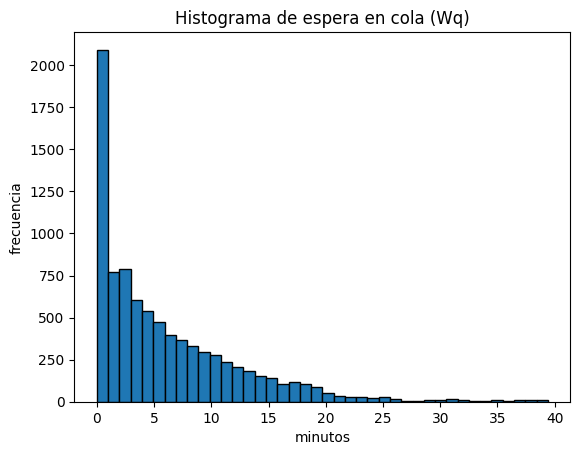

In [15]:
# Utilización observada: tiempo ocupado / tiempo disponible del servidor
utilizacion = monitor["busy_time"] / T if T > 0 else 0.0

# Promedios (solo con clientes completados)
Wq = statistics.mean(monitor["waits"]) if monitor["waits"] else 0.0
W  = statistics.mean(monitor["system_times"]) if monitor["system_times"] else 0.0

# Tasa efectiva de salida (clientes completados por unidad de tiempo)
lam_eff = monitor["departures"] / T if T > 0 else 0.0

# Ley de Little usando lambda efectivo
L  = lam_eff * W
Lq = lam_eff * Wq

# Percentiles (si hay datos)
p50 = np.percentile(monitor["waits"], 50) if monitor["waits"] else 0.0
p90 = np.percentile(monitor["waits"], 90) if monitor["waits"] else 0.0

print("utilización (obs):", round(utilizacion, 4))
print("Wq (obs):", round(Wq, 4))
print("W  (obs):", round(W, 4))
print("Lq (obs):", round(Lq, 4))
print("L  (obs):", round(L, 4))
print("p50(Wq):", round(p50, 4))
print("p90(Wq):", round(p90, 4))

plt.figure()
plt.hist(monitor["waits"], bins=40, edgecolor="black")
plt.title("Histograma de espera en cola (Wq)")
plt.xlabel("minutos")
plt.ylabel("frecuencia")
plt.show()


### Consolidación

Ahora que ya entendimos cada componente por separado, empaquetamos todo en una función `simular_mm1(...)` para poder:

- correr múltiples escenarios,
- comparar resultados,
- y reutilizar el modelo sin reescribir código.


In [16]:
def simular_mm1(lam, mu, T, seed=0):
    """
    Simula una cola M/M/1 con SimPy durante un horizonte T.
    
    Parámetros:
    - lam: tasa de llegadas (clientes/unidad de tiempo)
    - mu: tasa de servicio (clientes/unidad de tiempo)
    - T: horizonte de simulación
    - seed: semilla para reproducibilidad
    
    Retorna un diccionario con métricas y muestras (waits, system_times).
    """
    # Fijar semilla para que los resultados se puedan repetir
    random.seed(seed)
        
    # Monitor: aquí guardamos información para calcular métricas después
    monitor = {
        "arrivals": 0,        # número de clientes que llegaron
        "departures": 0,      # número de clientes que completaron servicio
        "busy_time": 0.0,     # tiempo total que el servidor estuvo ocupado
        "waits": [],          # esperas en cola (Wq) por cliente completado
        "system_times": []    # tiempos en el sistema (W) por cliente completado
    }

    monitor

    def cliente(env, servidor):
        """
        Proceso de un cliente:
        - llega en env.now
        - pide el recurso (servidor)
        - espera en cola si es necesario
        - se atiende por un tiempo exponencial
        - registra métricas al salir
        """
        # Tiempo de llegada (reloj simulado)
        t0 = env.now
        
        # Solicitar el servidor (Resource) dentro de un contexto
        with servidor.request() as req:
            # yield req: esperar hasta que el servidor esté disponible
            yield req
            
            # En este punto, el cliente ya obtuvo el servidor
            espera = env.now - t0     # tiempo en cola
            
            # Tiempo de servicio ~ Exp(mu)
            t_serv = random.expovariate(mu)
            
            # Acumular tiempo ocupado (para utilización)
            monitor["busy_time"] += t_serv
            
            # Simular servicio: el reloj avanza t_serv
            yield env.timeout(t_serv)
        
        # Al salir del "with", el servidor se libera automáticamente
        
        # Registrar métricas del cliente completado
        monitor["waits"].append(espera)
        monitor["system_times"].append(espera + t_serv)
        monitor["departures"] += 1

    def generador_llegadas(env, lam, servidor):
        """
        Genera llegadas:
        - espera interarribos ~ Exp(lam)
        - incrementa contador de llegadas
        - crea el proceso de cliente
        """
        while True:
            # Interarribo ~ Exp(lam)
            inter = random.expovariate(lam)
            
            # Esperar ese tiempo de interarribo
            yield env.timeout(inter)
            
            # Registrar llegada
            monitor["arrivals"] += 1
            
            # Lanzar el proceso del cliente
            env.process(cliente(env, servidor))

    # 1) Crear entorno (reloj + planificador)
    env = simpy.Environment()
    
    # 2) Crear el servidor (capacidad 1 => M/M/1)
    servidor = simpy.Resource(env, capacity=1)
    
    # 3) Registrar proceso de llegadas
    env.process(generador_llegadas(env, lam, servidor))
    
    # 4) Ejecutar simulación hasta T
    env.run(until=T)

    # ---------------------------
    # Métricas al finalizar
    # ---------------------------
    
    # Utilización observada: tiempo ocupado / tiempo total disponible
    util = monitor["busy_time"] / T if T > 0 else 0.0
    
    # Promedios (solo con clientes completados)
    Wq = statistics.mean(monitor["waits"]) if monitor["waits"] else 0.0
    W  = statistics.mean(monitor["system_times"]) if monitor["system_times"] else 0.0
    
    # Tasa efectiva de salida: clientes completados por unidad de tiempo
    lam_eff = monitor["departures"] / T if T > 0 else 0.0
    
    # Ley de Little (usando lambda efectivo)
    L  = lam_eff * W
    Lq = lam_eff * Wq
    
    return {
        "lam": lam, "mu": mu, "T": T,
        "rho": util,
        "Wq": Wq, "W": W, "Lq": Lq, "L": L,
        "arrivals": monitor["arrivals"],
        "departures": monitor["departures"],
        "waits_sample": monitor["waits"],
        "system_sample": monitor["system_times"]
    }


### Caso base y comparación con teoría

Elegimos parámetros base tales que $\lambda < \mu$ para que el sistema sea estable.

- $\lambda = 0.85$ clientes/min
- $\mu = 1.00$ clientes/min
- $T = 10\,000$ min

Luego comparamos simulación vs teoría.


In [17]:
lam = 0.85
mu = 1.00
T = 10_000

resultados_base = simular_mm1(lam, mu, T, seed=1)

print("Resultados simulación (base)")
print({
    "rho": round(resultados_base["rho"], 4),
    "Wq": round(resultados_base["Wq"], 4),
    "W": round(resultados_base["W"], 4),
    "Lq": round(resultados_base["Lq"], 4),
    "L": round(resultados_base["L"], 4),
})

if lam < mu:
    theo = teorico_mm1(lam, mu)
    print("\nTeoría M/M/1 (lam < mu)")
    print({k: round(v, 4) for k, v in theo.items()})
else:
    print("\nlam >= mu: no hay régimen estacionario para comparación teórica.")


Resultados simulación (base)
{'rho': 0.8496, 'Wq': 5.4149, 'W': 6.4141, 'Lq': 4.6021, 'L': 5.4513}

Teoría M/M/1 (lam < mu)
{'rho': 0.85, 'W': 6.6667, 'Wq': 5.6667, 'L': 5.6667, 'Lq': 4.8167}


### Percentiles y propuesta de SLA

Además de promedios, en operación suele importar el comportamiento “típico” y “malo”:

- p50: mediana (50% de clientes espera menos que esto)
- p90: 90% de clientes espera menos que esto

Un SLA (Service Level Agreement) típico sería:
- “el 90% de los clientes espera menos de $X$ minutos”.


p50 espera en cola (Wq): 3.543 min
p90 espera en cola (Wq): 13.288 min
SLA sugerido: 90% espera < 13.288 min


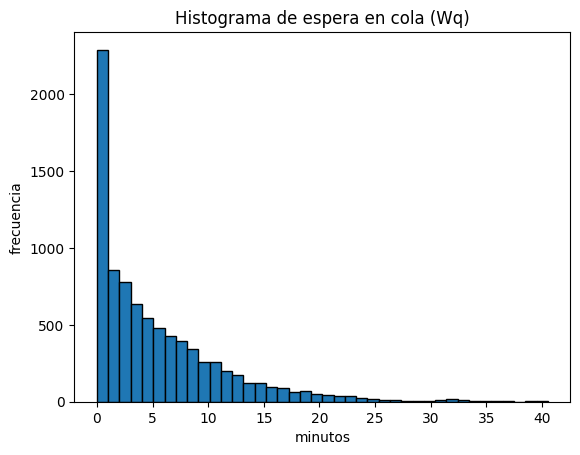

In [18]:
waits = resultados_base["waits_sample"]
system_times = resultados_base["system_sample"]

p50 = np.percentile(waits, 50) if waits else 0.0
p90 = np.percentile(waits, 90) if waits else 0.0

print(f"p50 espera en cola (Wq): {p50:.3f} min")
print(f"p90 espera en cola (Wq): {p90:.3f} min")
print(f"SLA sugerido: 90% espera < {p90:.3f} min")

plt.figure()
plt.hist(waits, bins=40, edgecolor="black")
plt.title("Histograma de espera en cola (Wq)")
plt.xlabel("minutos")
plt.ylabel("frecuencia")
plt.show()


## Experimentos rápidos

Vamos a comparar 3 escenarios:

- **Base**: $\lambda=0.85$, $\mu=1.00$
- **A (mayor demanda)**: $\lambda=0.95$, $\mu=1.00$
- **B (mayor capacidad)**: $\lambda=0.85$, $\mu=1.10$

La hipótesis esperada:
- subir $\lambda$ aumenta la utilización y dispara $W_q$ y $W$.
- subir $\mu$ reduce $W_q$ y $W$ y baja la utilización.


In [19]:
escenarios = [
    {"escenario": "base", "lam": 0.85, "mu": 1.00},
    {"escenario": "A_mayor_demanda", "lam": 0.95, "mu": 1.00},
    {"escenario": "B_mayor_capacidad", "lam": 0.85, "mu": 1.10},
]

filas = []
for e in escenarios:
    r = simular_mm1(e["lam"], e["mu"], T, seed=100)
    filas.append({
        "escenario": e["escenario"],
        "lam": e["lam"],
        "mu": e["mu"],
        "rho": r["rho"],
        "Wq": r["Wq"],
        "W": r["W"],
        "Lq": r["Lq"],
        "L": r["L"],
        "departures": r["departures"],
    })

df = pd.DataFrame(filas)

# redondeo para lectura
df_round = df.copy()
for c in ["rho", "Wq", "W", "Lq", "L"]:
    df_round[c] = df_round[c].round(4)

df_round


,escenario,lam,mu,rho,Wq,W,Lq,L,departures
0,base,0.85,1.0,0.8559,6.3275,7.3314,5.3929,6.2486,8523
1,A_mayor_demanda,0.95,1.0,0.9590,22.8807,23.8864,21.8190,22.7780,9536
2,B_mayor_capacidad,0.85,1.1,0.7888,3.3621,4.2793,2.8910,3.6798,8599


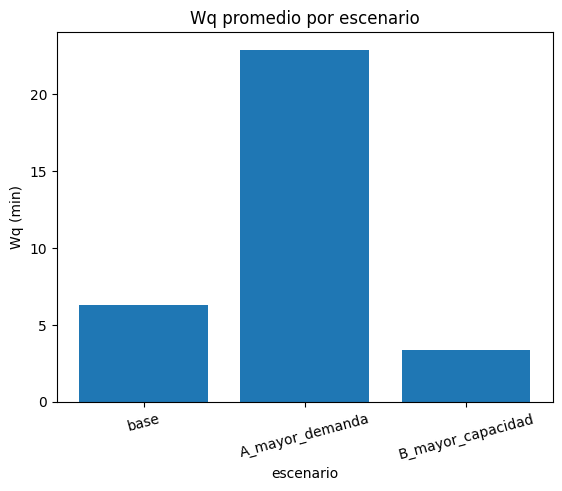

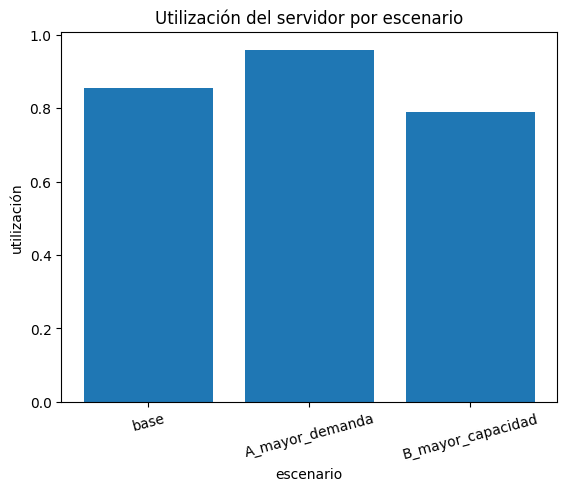

In [20]:
plt.figure()
plt.bar(df["escenario"], df["Wq"])
plt.title("Wq promedio por escenario")
plt.xlabel("escenario")
plt.ylabel("Wq (min)")
plt.xticks(rotation=15)
plt.show()

plt.figure()
plt.bar(df["escenario"], df["rho"])
plt.title("Utilización del servidor por escenario")
plt.xlabel("escenario")
plt.ylabel("utilización")
plt.xticks(rotation=15)
plt.show()


### Variación porcentual respecto al escenario base


Para comunicar resultados, muchas veces es útil reportar cambios relativos (%):

$$
\%\Delta = 100\cdot\frac{\text{métrica} - \text{métrica}_{base}}{\text{métrica}_{base}}
$$


In [21]:
base = df.loc[df["escenario"] == "base"].iloc[0]
cols_cmp = ["rho", "Wq", "W", "Lq", "L"]

df_cmp = df.copy()
for c in cols_cmp:
    df_cmp[c + "_vs_base_%"] = 100 * (df[c] - base[c]) / base[c]

# redondeo para lectura
for c in [col for col in df_cmp.columns if col.endswith("_vs_base_%")]:
    df_cmp[c] = df_cmp[c].round(2)

df_cmp


,escenario,lam,mu,rho,Wq,W,Lq,L,departures,rho_vs_base_%,Wq_vs_base_%,W_vs_base_%,Lq_vs_base_%,L_vs_base_%
0,base,0.85,1.0,0.855901,6.327505,7.331441,5.392932,6.248587,8523,0.00,0.00,0.00,0.00,0.00
1,A_mayor_demanda,0.95,1.0,0.959033,22.880696,23.886373,21.819031,22.778045,9536,12.05,261.61,225.81,304.59,264.53
2,B_mayor_capacidad,0.85,1.1,0.788849,3.362057,4.279320,2.891033,3.679787,8599,-7.83,-46.87,-41.63,-46.39,-41.11


## Ejercicio Práctico: Farmacia de Ventanilla (M/M/1)

Una farmacia atiende a los clientes en una única ventanilla. Los clientes llegan de manera aleatoria y forman una cola FIFO. El tiempo de atención también es aleatorio. Cuando el sistema está ocupado, los clientes esperan y nadie abandona.

### Supuestos del modelo
- llegadas $\sim$ Poisson con tasa $\lambda$
- servicio $\sim$ Exponencial con tasa $\mu$
- un solo servidor con cola FIFO
- sin abandonos

### Parámetros
- $\lambda = 0.85$ clientes por minuto
- $\mu  = 1.00$ clientes por minuto
- $T   = 10\,000$ minutos

### Para realizar

1. Estimar por simulación:
   - utilización del servidor
   - tiempos promedio $W_q$ y $W$
   - números promedio $L_q$ y $L$ vía Ley de Little con la tasa efectiva de salida

2. Calcular valores teóricos (si $\lambda < \mu$) y compararlos con la simulación.

3. Reportar los percentiles p50 y p90 de la espera en cola.

4. Proponer un SLA del tipo:  
   “el 90% de los clientes espera menos de $X$ minutos”.

5. Experimentos:
   - Escenario A: aumenta la demanda a $\lambda = 0.95$ y comenta el efecto.
   - Escenario B: mejora la capacidad a $\mu = 1.10$ con $\lambda = 0.85$.

6. Grafica información relevante y calcula la variación porcentual de cada escenario respecto al base.


## Solución:

In [22]:
# Puedes reutilizar simular_mm1(...) y teorico_mm1(...)

# 1) Caso base
lam_base = 0.85
mu_base = 1.00
T = 10_000

resultados_base = simular_mm1(lam_base, mu_base, T, seed=10)

# 2) Teoría (si aplica)
if lam_base < mu_base:
    theo_base = teorico_mm1(lam_base, mu_base)
else:
    theo_base = None

# 3) Percentiles
waits_base = resultados_base["waits_sample"]
p50 = np.percentile(waits_base, 50)
p90 = np.percentile(waits_base, 90)

print("Base (simulación)")
print({
    "rho": round(resultados_base["rho"], 4),
    "Wq": round(resultados_base["Wq"], 4),
    "W": round(resultados_base["W"], 4),
    "Lq": round(resultados_base["Lq"], 4),
    "L": round(resultados_base["L"], 4),
})

if theo_base is not None:
    print("\nBase (teoría)")
    print({k: round(v, 4) for k, v in theo_base.items()})


Base (simulación)
{'rho': 0.8527, 'Wq': 6.7904, 'W': 7.7844, 'Lq': 5.8248, 'L': 6.6775}

Base (teoría)
{'rho': 0.85, 'W': 6.6667, 'Wq': 5.6667, 'L': 5.6667, 'Lq': 4.8167}
